In [ ]:
#Applicable only if you are building it on Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi
%cd /content/drive/My Drive/comp4211Proj/omniglot/python
!ls

Fri May 22 12:50:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
from os import walk
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import random

In [ ]:
# setting the root directories and categories of the images
# root_dir = './images_background/'
root_dir = './images_evaluation/'
categories = [[folder, os.listdir(root_dir + folder)] for folder in os.listdir(root_dir)  if not folder.startswith('.') ]

In [ ]:
# creating the pairs of images for inputs, same character label = 1, vice versa
class OmniglotDataset(Dataset):
    def __init__(self, categories, root_dir, setSize, transform=None):
        self.categories = categories
        self.root_dir = root_dir
        self.transform = transform
        self.setSize = setSize
    def __len__(self):
        return self.setSize
    def __getitem__(self, idx):
        img1 = None
        img2 = None
        label = None
        if idx % 2 == 0: # select the same character for both images
            category = random.choice(categories)
            character = random.choice(category[1])
            imgDir = root_dir + category[0] + '/' + character
            img1Name = random.choice(os.listdir(imgDir))
            img2Name = random.choice(os.listdir(imgDir))
            img1 = Image.open(imgDir + '/' + img1Name)
            img2 = Image.open(imgDir + '/' + img2Name)
            # print(imgDir+'/'+img1Name)
            # print(imgDir+'/'+img2Name)
            label = 1.0
        else: # select a different character for both images
            category1, category2 = random.choice(categories), random.choice(categories)
            category1, category2 = random.choice(categories), random.choice(categories)
            character1, character2 = random.choice(category1[1]), random.choice(category2[1])
            imgDir1, imgDir2 = root_dir + category1[0] + '/' + character1, root_dir + category2[0] + '/' + character2
            img1Name = random.choice(os.listdir(imgDir1))
            img2Name = random.choice(os.listdir(imgDir2))
            while img1Name == img2Name:
                img2Name = random.choice(os.listdir(imgDir2))
            label = 0.0
            img1 = Image.open(imgDir1 + '/' + img1Name)
            img2 = Image.open(imgDir2 + '/' + img2Name)
#         plt.imshow(img1)
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2, torch.from_numpy(np.array([label], dtype=np.float32))          


In [ ]:
# creates n-way one shot learning evaluation
class NWayOneShotEvalSet(Dataset):
    def __init__(self, categories, root_dir, setSize, numWay, transform=None):
        self.categories = categories
        self.root_dir = root_dir
        self.setSize = setSize
        self.numWay = numWay
        self.transform = transform
    def __len__(self):
        return self.setSize
    def __getitem__(self, idx):
        # find one main image
        category = random.choice(categories)
        character = random.choice(category[1])
        imgDir = root_dir + category[0] + '/' + character
        imgName = random.choice(os.listdir(imgDir))
        mainImg = Image.open(imgDir + '/' + imgName)
        # print(imgDir + '/' + imgName)
        if self.transform:
            mainImg = self.transform(mainImg)
        
        # find n numbers of distinct images, 1 in the same set as the main
        testSet = []
        label = np.random.randint(self.numWay)
        for i in range(self.numWay):
            testImgDir = imgDir
            testImgName = ''
            if i == label:
                testImgName = random.choice(os.listdir(imgDir))
            else:
                testCategory = random.choice(categories)
                testCharacter = random.choice(testCategory[1])
                testImgDir = root_dir + testCategory[0] + '/' + testCharacter
                while testImgDir == imgDir:
                    testImgDir = root_dir + testCategory[0] + '/' + testCharacter
                testImgName = random.choice(os.listdir(testImgDir))
            testImg = Image.open(testImgDir + '/' + testImgName)
            if self.transform:
                testImg = self.transform(testImg)
            testSet.append(testImg)
        # plt.imshow()
        return mainImg, testSet, torch.from_numpy(np.array([label], dtype = int))

In [ ]:
# choose a training dataset size and further divide it into train and validation set 80:20
dataSize = 10000 # self-defined dataset size
TRAIN_PCT = 0.8 # percentage of entire dataset for training
train_size = int(dataSize * TRAIN_PCT)
val_size = dataSize - train_size

transformations = transforms.Compose(
    [transforms.ToTensor()]) 

omniglotDataset = OmniglotDataset(categories, root_dir, dataSize, transformations)
train_set, val_set = random_split(omniglotDataset, [train_size, val_size])
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, num_workers=16)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=16, shuffle=True)

In [ ]:
# create the test set for final testing
testSize = 5000 
numWay = 20
test_set = NWayOneShotEvalSet(categories, root_dir, testSize, numWay, transformations)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 2, shuffle=True)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7fa8a6f72240>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


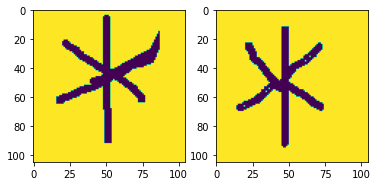

In [ ]:
# showing a sample input of a training set
count0 = 0
count1 = 0
for img1, img2, label in train_loader:
    print()
    if label[0] == 1.0:
        print(img1[0])
        plt.subplot(1,2,1)
        plt.imshow(img1[0][0])
        plt.subplot(1,2,2)
        plt.imshow(img2[0][0])
        # print(label)
        break
    # break

In [ ]:
# showing a sample input of the testing set
count = 0
for mainImg, imgset, label in test_loader:
    # print(len(imgset))
    # print(label)
    # print(imgset.shape)
    if label != 1:
        for count, img in enumerate(imgset):
          plt.subplot(1, len(imgset)+1, count+1)
          plt.imshow(img[0][0])
          # print(img.shape)
        print(mainImg.shape)
        plt.subplot(1, len(imgset)+1, len(imgset)+1)
        plt.imshow(mainImg[0][0])
        count += 1
        break
    # break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#Different network structures, the commented out are the different experimenting structures
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Koch et al.
        # Conv2d(input_channels, output_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 64, 10) 
        self.conv2 = nn.Conv2d(64, 128, 7)  
        self.conv3 = nn.Conv2d(128, 128, 4)
        self.conv4 = nn.Conv2d(128, 256, 4)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fcOut = nn.Linear(4096, 1)
        self.sigmoid = nn.Sigmoid()

        # VGG16
        # # dataiter = iter(train_loader)
        # # img1, img2, label = dataiter.next()
        # # print(img1.shape)
        # self.conv11 = nn.Conv2d(1, 64, 3) 
        # self.conv12 = nn.Conv2d(64, 64, 3)  
        # self.conv21 = nn.Conv2d(64, 128, 3)
        # self.conv22 = nn.Conv2d(128, 128, 3)
        # self.conv31 = nn.Conv2d(128, 256, 3) 
        # self.conv32 = nn.Conv2d(256, 256, 3)  
        # self.conv33 = nn.Conv2d(256, 256, 3)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.fc1 = nn.Linear(256 * 8 * 8, 4096)
        # self.fc2 = nn.Linear(4096, 4096)
        # self.fcOut = nn.Linear(4096, 1)
        # self.sigmoid = nn.Sigmoid()
        # # x = self.conv11(img1)
        # # x = self.conv12(x)
        # # x = self.pool(x)
        # # x = self.conv21(x)
        # # x = self.conv22(x)
        # # x = self.pool(x)
        # # x = self.conv31(x)
        # # x = self.conv32(x)
        # # x = self.conv33(x)
        # # x = self.pool(x)
        # # print(x.shape)
    
    def convs(self, x):

        # Koch et al.
        # out_dim = in_dim - kernel_size + 1  
        #1, 105, 105
        x = F.relu(self.bn1(self.conv1(x)))
        # 64, 96, 96
        x = F.max_pool2d(x, (2,2))
        # 64, 48, 48
        x = F.relu(self.bn2(self.conv2(x)))
        # 128, 42, 42
        x = F.max_pool2d(x, (2,2))
        # 128, 21, 21
        x = F.relu(self.bn3(self.conv3(x)))
        # 128, 18, 18
        x = F.max_pool2d(x, (2,2))
        # 128, 9, 9
        x = F.relu(self.bn4(self.conv4(x)))
        # 256, 6, 6
        return x

        # VGG16
        # x = F.relu(self.conv11(x))
        # x = F.relu(self.conv12(x))
        # x = F.max_pool2d(x, (2,2))
        # x = F.relu(self.conv21(x))
        # x = F.relu(self.conv22(x))
        # x = F.max_pool2d(x, (2,2))
        # x = F.relu(self.conv31(x))
        # x = F.relu(self.conv32(x))
        # x = F.relu(self.conv33(x))
        # x = F.max_pool2d(x, (2,2))
        # return x

    def forward(self, x1, x2):
        x1 = self.convs(x1)

        # Koch et al.
        x1 = x1.view(-1, 256 * 6 * 6)
        x1 = self.sigmoid(self.fc1(x1))

        # VGG16
        # x1 = x1.view(-1, 256 * 8 * 8)
        # x1 = self.fc1(x1)
        # x1 = self.sigmoid(self.fc2(x1))
        
        x2 = self.convs(x2)

        # Koch et al.
        x2 = x2.view(-1, 256 * 6 * 6)
        x2 = self.sigmoid(self.fc1(x2))

        # VGG16
        # x2 = x2.view(-1, 256 * 8 * 8)
        # x2 = self.fc1(x2)
        # x2 = self.sigmoid(self.fc2(x2))

        x = torch.abs(x1 - x2)
        x = self.fcOut(x)
        return x

In [ ]:
#creating the original network and couting the paramenters of different networks
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
siameseBaseLine = Net()
siameseBaseLine = siameseBaseLine.to(device)

def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(siameseBaseLine)

The model architecture:

 Net(
  (conv1): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fcOut): Linear(in_features=4096, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

The model has 38,952,897 trainable parameters


In [ ]:
# saving and loading checkpoint mechanisms
def save_checkpoint(save_path, model, optimizer, val_loss):
    if save_path==None:
        return
    save_path = save_path 
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'val_loss': val_loss}

    torch.save(state_dict, save_path)

    print(f'Model saved to ==> {save_path}')

def load_checkpoint(model, optimizer):
    save_path = f'siameseNet-batchnorm50.pt'
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [ ]:
# training and validation after every epoch
def train(model, train_loader, val_loader, num_epochs, criterion, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    cur_step = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        print("Starting epoch " + str(epoch+1))
        for img1, img2, labels in train_loader:
            
            # Forward
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for img1, img2, labels in val_loader:
                img1 = img1.to(device)
                img2 = img2.to(device)
                labels = labels.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            save_checkpoint(save_name, model, optimizer, best_val_loss)
    
    print("Finished Training")  
    return train_losses, val_losses  

# evaluation metrics
def eval(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        print('Starting Iteration')
        count = 0
        for mainImg, imgSets, label in test_loader:
            mainImg = mainImg.to(device)
            predVal = 0
            pred = -1
            for i, testImg in enumerate(imgSets):
                testImg = testImg.to(device)
                output = model(mainImg, testImg)
                if output > predVal:
                    pred = i
                    predVal = output
            label = label.to(device)
            if pred == label:
                correct += 1
            count += 1
            if count % 20 == 0:
                print("Current Count is: {}".format(count))
                print('Accuracy on n way: {}'.format(correct/count))



In [ ]:
# actual training
import torch.optim as optim

optimizer = optim.Adam(siameseBaseLine.parameters(), lr = 0.0006)
num_epochs = 50
criterion = nn.BCEWithLogitsLoss()
save_path = 'siameseNet-batchnorm50.pt'
train_losses, val_losses = train(siameseBaseLine, train_loader, val_loader, num_epochs, criterion, save_path)

Starting epoch 1
Epoch [1/50],Train Loss: 0.5549, Valid Loss: 0.48125232
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 2
Epoch [2/50],Train Loss: 0.4668, Valid Loss: 0.42635091
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 3
Epoch [3/50],Train Loss: 0.3985, Valid Loss: 0.36831688
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 4
Epoch [4/50],Train Loss: 0.3517, Valid Loss: 0.31845768
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 5
Epoch [5/50],Train Loss: 0.3155, Valid Loss: 0.29446547
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 6
Epoch [6/50],Train Loss: 0.2865, Valid Loss: 0.26804872
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 7
Epoch [7/50],Train Loss: 0.2638, Valid Loss: 0.26452624
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 8
Epoch [8/50],Train Loss: 0.2445, Valid Loss: 0.22926572
Model saved to ==> siameseNet-batchnorm50.pt
Starting epoch 9
Epoch [9/50],Train Loss: 0.2301, Valid 

In [ ]:
# Evaluation on previously saved models
import torch.optim as optim
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0006)


num_epochs = 10
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer)

print(best_val_loss)
eval(load_model, test_loader)

Model loaded from <== siameseNet-batchnorm50.pt
0.06619010965561553
Starting Iteration
Current Count is: 20
Accuracy on n way: 0.75
Current Count is: 40
Accuracy on n way: 0.8


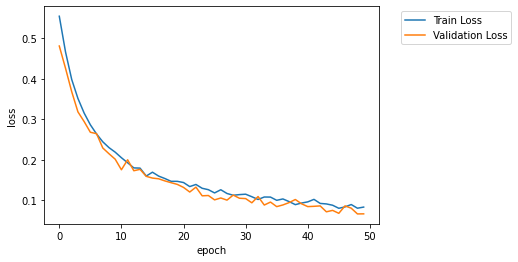

In [ ]:
#plotting of training and validation loss
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label="Validation Loss")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


In [ ]:
"""How to use the evaluation n way:

# Set the parameters
testSize = 5000 # how big you want your test size to be
numWay = 4 # how many ways metric

# Create the dataset for it and put it into dataloader
test_set = NWayOneShotEvalSet(categories, root_dir, testSize, numWay, transformations) 
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 2)


# Load the models (the name of the loaded model can be changed in the load_checkpoint() function)
load_model = Net().to(device)
load_optimizer = optim.Adam(load_model.parameters(), lr=0.0006)


num_epochs = 10
eval_every = 1000
total_step = len(train_loader)*num_epochs
best_val_loss = load_checkpoint(load_model, load_optimizer)

print(best_val_loss)

# Evaluate from the test loader 

eval(load_model, test_loader)

"""